<a href="https://colab.research.google.com/github/rrizwan98/Natural-Language-Processing-NLp-/blob/main/English_French_seqtoseq_learning_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/My Drive/english to french.zip'
with ZipFile (file_name,'r')as zip:
  zip.extractall()
  print('raza')

raza


In [ ]:
import os, sys

import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url='/content/eng_-french.csv'
data = pd.read_csv(url, header='infer')
df = data[0:20000]
df

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
19995,It's a pipe dream.,C'est un projet chimérique.
19996,It's a rented car.,C'est une voiture de location.
19997,It's a small town.,C'est une petite ville.
19998,It's a true story.,C'est une histoire vraie.


In [ ]:
english_text = df['English words/sentences']
french_text = df['French words/sentences']


In [ ]:
import re
english = []
french = []
for i in range(len(english_text)):
    text = english_text[i].lower()
    text = re.sub('[^a-zA-Z]',' ',text)
    english.append(text)
    

for i in range(len(french_text)):
    ftext = french_text[i].lower()
    ftext = (re.sub("[^a-zA-Z' àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]",' ',ftext))
    french.append("START_ " + ftext + " _END")

In [ ]:
english


['hi ',
 'run ',
 'run ',
 'who ',
 'wow ',
 'fire ',
 'help ',
 'jump ',
 'stop ',
 'stop ',
 'stop ',
 'wait ',
 'wait ',
 'go on ',
 'go on ',
 'go on ',
 'hello ',
 'hello ',
 'i see ',
 'i try ',
 'i won ',
 'i won ',
 'i won ',
 'oh no ',
 'attack ',
 'attack ',
 'cheers ',
 'cheers ',
 'cheers ',
 'cheers ',
 'get up ',
 'go now ',
 'go now ',
 'go now ',
 'got it ',
 'got it ',
 'got it ',
 'got it ',
 'got it ',
 'hop in ',
 'hop in ',
 'hug me ',
 'hug me ',
 'i fell ',
 'i fell ',
 'i know ',
 'i left ',
 'i left ',
 'i lied ',
 'i lost ',
 'i paid ',
 'i m    ',
 'i m ok ',
 'i m ok ',
 'listen ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'really ',
 'really ',
 'really ',
 'thanks ',
 'we try ',
 'we won ',
 'we won ',
 'we won ',
 'we won ',
 'ask tom ',
 'awesome ',
 'be calm ',
 'be calm ',
 'be calm ',
 'be cool ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be kind '

In [ ]:

#Vocabulary of English
all_eng_words = set()
for i in english:
    for j in i.split():
        all_eng_words.add(j)

#vocabulary of french
all_fre_words = set()
for i in french:
    for j in i.split():
        all_fre_words.add(j)

#maxlen of the source sequence
max_length_src = 0
for i in english:
    a = len(i.split())
    if a>max_length_src:
        max_length_src = a
        
#maxlen of the target sequence
max_length_tar = 0
for j in french:
    b = len(j.split())
    if b>max_length_tar:
        max_length_tar = b
        

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_fre_words))

# Calculate Vocab size for both source and targe
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_fre_words)


#indexs for input and target sequences
input_index = dict([(words,i) for i,words in enumerate(input_words)])
target_index = dict([(word, i) for i, word in enumerate(target_words)])

reverse_input_index = dict((i, word) for word, i in input_index.items())
reverse_target_index = dict((i, word) for word, i in target_index.items())

In [ ]:
print(max_length_src)
print(max_length_tar)
print(num_encoder_tokens)
print(num_decoder_tokens)

6
14
3417
6620


In [ ]:
encoder_input_data = np.zeros((10000, max_length_src, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((10000, max_length_tar, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((10000, max_length_tar, num_decoder_tokens),dtype='float32')

In [ ]:
for j in range(10000):
    for i,text in enumerate(english[j].split()):
        encoder_input_data[j,i,input_index[text]] = 1.

for j in range(10000):
    for i,text in enumerate(french[j].split()):
        decoder_input_data[j,i,target_index[text]] = 1.
        if i>0:
            decoder_target_data[j,i-1,target_index[text]] = 1.

In [ ]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional

In [ ]:
batch_size = 64
epochs = 100
latent_dim = 256 #size of the lstms hidden state

In [ ]:
#Time to bulid the model

#inputs for the encoder
encoder_inputs = Input(shape=(None,num_encoder_tokens))
#encoder lstm
encod_lstm = (LSTM(latent_dim,return_state = True))
encoder_output,state_h,state_c = encod_lstm(encoder_inputs)

#hidden from encoder to pass to the decoder as initial hidden state
encoder_states = [state_h,state_c]

#inputs for the decoder
decoder_inputs = Input(shape=(None,num_decoder_tokens))
#decoder lstm 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_output,_,_= decoder_lstm(decoder_inputs,initial_state = encoder_states)
#The decoder output is passed through the softmax layer that will learn to classify the correct french character
#Activation functions are used to transform vectors before computing the loss in the training phase
#for more on softmax https://gombru.github.io/2018/05/23/cross_entropy_loss/
dense_layer = Dense(num_decoder_tokens, activation='softmax')
decoder_output = dense_layer(decoder_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_output)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3417)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6620)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 3762176     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  7042048     input_2[0][0]                    
                                                                 lstm[0][1]            

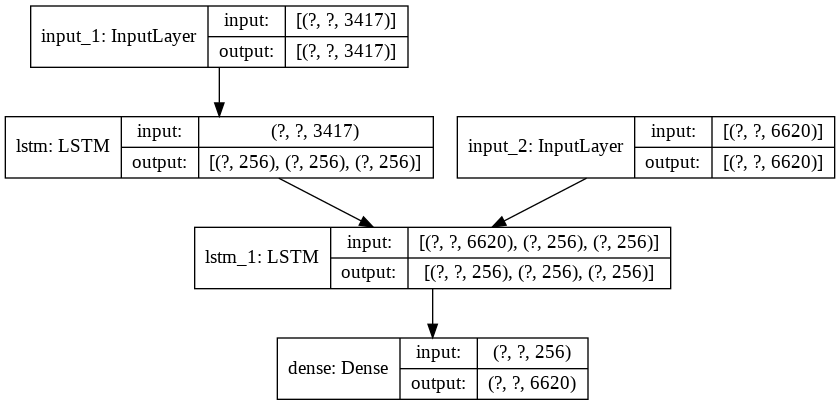

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size= 64,epochs= 2,validation_split=0.2)

Epoch 1/2
125/125 [==============================] - 13s 101ms/step - loss: 1.5989 - accuracy: 0.0863 - val_loss: 1.6956 - val_accuracy: 0.0869
Epoch 2/2
125/125 [==============================] - 12s 94ms/step - loss: 1.3875 - accuracy: 0.0977 - val_loss: 1.6115 - val_accuracy: 0.0940


In [ ]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_h = Input(shape=(latent_dim,))
decoder_state_c = Input(shape=(latent_dim,))
decode_state = [decoder_state_h,decoder_state_c]

decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs,initial_state = decode_state)
decoder_states = [state_h, state_c]
decoder_outputs = dense_layer(decoder_outputs)

decoder_model = Model([decoder_inputs] + decode_state,[decoder_outputs] + decoder_states)

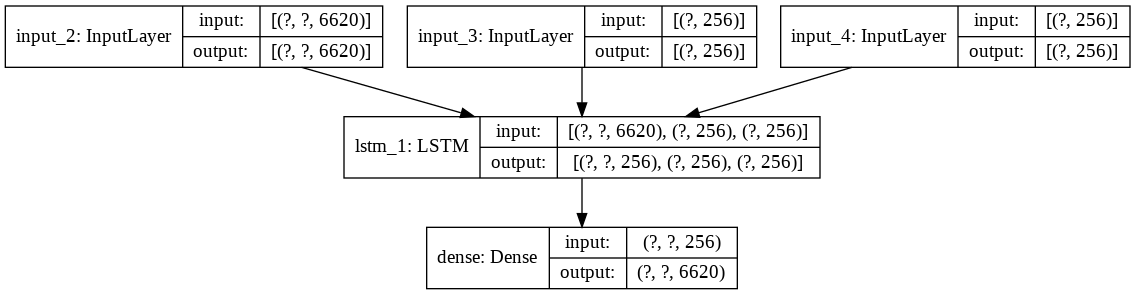

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # encode the input sequence to get the internal state vectors.
    states_value = encoder_model.predict(input_seq)
  
    # generate empty target sequence of length 1 with only the start character
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_index['START_']] = 1.
  
    # output sequence loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    
        # sample a token and add the corresponding character to the 
        # decoded sequence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_index[sampled_token_index]
        
        if (sampled_char == "_END" or len(decoded_sentence) > max_length_tar):
            stop_condition = True
            break
            
        decoded_sentence += sampled_char
        decoded_sentence +=' '
      
        # update the target sequence (length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
    
        # update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
toks = ['i love you','run fast','she is the ','my name is tom']
for t in toks:
    input_sentence = t
    test_sentence_tokenized = np.zeros((1, max_length_src, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence.split()):
        test_sentence_tokenized[0, t, input_index[char]] = 1.
    print(input_sentence)
    print(decode_sequence(test_sentence_tokenized))
    print(' ')

i love you
je suis 
 
run fast
c'est 
 
she is the 
il est 
 
my name is tom
c'est est 
 
